<a href="https://colab.research.google.com/github/TioSatrio100/Image-Classification-Of-Rice-Varieties/blob/main/ImageClassificationOfRiceVarieties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
import tensorflow as tf
import pathlib
import zipfile,os

In [ ]:

local_zip = 'Rice_Image_Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('rps')
zip_ref.close()

In [ ]:
FILE_PATH = 'rps/Rice_Image_Dataset'

In [ ]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 64

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

train_generator = train_datagen.flow_from_directory(
    FILE_PATH,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    FILE_PATH,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset='validation'
)

target_names = ['Arborio', 'Basmati', 'Jasmine', 'Karacadag', 'Ipsala']

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [ ]:


model = Sequential([
    Conv2D(filters = 16, kernel_size = (5, 5), padding = 'Same', activation = 'relu', input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.2),
    BatchNormalization(),

    Conv2D(filters = 32, kernel_size = (3, 3), padding = 'Same', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
    Dropout(0.2),

    Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping

class TargetCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95):
      print("\nAccuracy and Validation Accuracy has reached 95%!\nStop Train!")
      self.model.stop_training = True
Target = TargetCallback()

EarlyStop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.0001,
    patience = 5,
    verbose = 1,
    mode = 'auto'
)

In [ ]:
myhistory = model.fit(
    train_generator,
    epochs =  100,
    validation_data = val_generator,
    callbacks = [Target, EarlyStop],
    verbose = 1
)


Epoch 1/100
938/938 [==============================] - 2327s 2s/step - loss: 0.1748 - accuracy: 0.9419 - val_loss: 0.0372 - val_accuracy: 0.9883
Epoch 2/100
938/938 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.9782
Accuracy and Validation Accuracy has reached 95%!
Stop Train!
938/938 [==============================] - 2328s 2s/step - loss: 0.0693 - accuracy: 0.9782 - val_loss: 0.0943 - val_accuracy: 0.9643


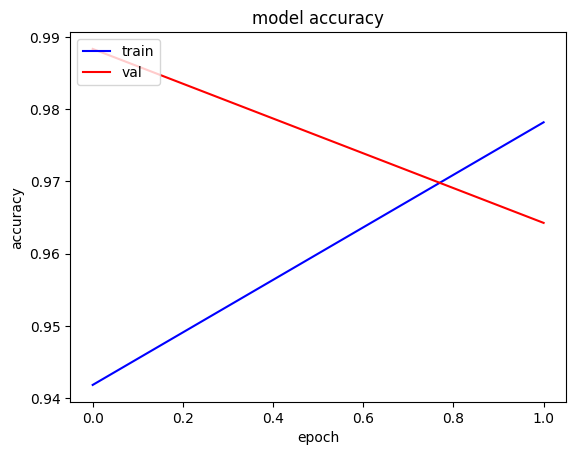

<function matplotlib.pyplot.show(close=None, block=None)>

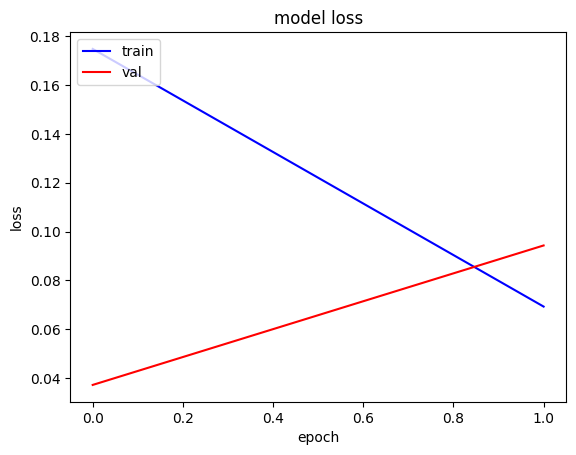

In [ ]:
acc = myhistory.history['accuracy']
val_acc = myhistory.history['val_accuracy']

loss = myhistory.history['loss']
val_loss = myhistory.history['val_loss']

plt.plot(acc, color='blue')
plt.plot(val_acc, color='red')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(loss, color='blue')
plt.plot(val_loss, color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show

In [ ]:


export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('RiceModel.tflite')
tflite_model_file.write_bytes(tflite_model)

5412200